In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score

from pandas import read_csv, unique

import numpy as np
import pandas as pd

from scipy.interpolate import interp1d
from scipy.stats import mode

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from tensorflow import stack
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dropout, Dense
from keras.layers import Dense, GlobalAveragePooling1D, BatchNormalization, MaxPool1D, Reshape, Activation
from tensorflow.keras.layers import Conv1D, Flatten, Reshape, MaxPooling1D
from keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE

In [2]:
import pandas as pd

filepath = 'C:/AI_study/dataset/'
# Load all 9 files as a list
filenames = [
    'S01R01.txt', 'S01R02.txt', 'S02R01.txt', 'S02R02.txt', 'S03R01.txt', 'S03R02.txt',
    'S03R03.txt', 'S04R01.txt', 'S05R01.txt', 'S05R02.txt', 'S06R01.txt', 'S06R02.txt',
    'S07R02.txt', 'S08R01.txt', 'S09R01.txt', 'S10R01.txt'
]

# Create an empty list to store DataFrames
dfs = []

# Iterate over each filename, load the CSV file, and append the DataFrame to the list
for filename in filenames:
    df = pd.read_csv(filepath + filename, sep="\s+", header=None)
    user_number = int(filename[1:3])
    df['User_Number'] = user_number
    dfs.append(df)

# Concatenate all DataFrames in the list into a single DataFrame
df = pd.concat(dfs, ignore_index=True)

# Set column names
columns = "TS, Ankel_1,Ankel_2,Ankel_3,Thigh_1,Thigh_2,Thigh_3,Trunk_1,Trunk_2,Trunk_3,status,User_Number".split(",")
df.columns = columns

print(df)

              TS   Ankel_1  Ankel_2  Ankel_3  Thigh_1  Thigh_2  Thigh_3  \
0             15        70       39     -970        0        0        0   
1             31        70       39     -970        0        0        0   
2             46        60       49     -960        0        0        0   
3             62        60       49     -960        0        0        0   
4             78        50       39     -960        0        0        0   
...          ...       ...      ...      ...      ...      ...      ...   
1798357  3020296      -131      107     -960        0        0        0   
1798358  3020312      -121      127     -970        0        0        0   
1798359  3020328      -141      117     -960        0        0        0   
1798360  3020343      -131      127     -980        0        0        0   
1798361  3020359      -141        0        0        0        0        0   

         Trunk_1  Trunk_2  Trunk_3  status  User_Number  
0              0        0        0       

In [3]:
df.head()

,TS,Ankel_1,Ankel_2,Ankel_3,Thigh_1,Thigh_2,Thigh_3,Trunk_1,Trunk_2,Trunk_3,status,User_Number
0,15,70,39,-970,0,0,0,0,0,0,0,1
1,31,70,39,-970,0,0,0,0,0,0,0,1
2,46,60,49,-960,0,0,0,0,0,0,0,1
3,62,60,49,-960,0,0,0,0,0,0,0,1
4,78,50,39,-960,0,0,0,0,0,0,0,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1798362 entries, 0 to 1798361
Data columns (total 12 columns):
 #   Column       Dtype
---  ------       -----
 0   TS           int64
 1    Ankel_1     int64
 2   Ankel_2      int64
 3   Ankel_3      int64
 4   Thigh_1      int64
 5   Thigh_2      int64
 6   Thigh_3      int64
 7   Trunk_1      int64
 8   Trunk_2      int64
 9   Trunk_3      int64
 10  status       int64
 11  User_Number  int64
dtypes: int64(12)
memory usage: 164.6 MB


In [5]:
df.describe()

,TS,Ankel_1,Ankel_2,Ankel_3,Thigh_1,Thigh_2,Thigh_3,Trunk_1,Trunk_2,Trunk_3,status,User_Number
count,1.798362e+06,1.798362e+06,1.798362e+06,1.798362e+06,1.798362e+06,1.798362e+06,1.798362e+06,1.798362e+06,1.798362e+06,1.798362e+06,1.798362e+06,1.798362e+06
mean,1.077208e+06,-5.840035e+01,8.205787e+02,5.888554e+01,-2.079832e+01,6.020473e+02,-3.875299e+01,4.821141e+01,7.631992e+02,-1.167351e+02,6.525399e-01,5.211849e+00
std,7.637586e+05,5.273884e+02,4.954709e+02,5.610358e+02,5.378507e+02,4.358368e+02,4.883318e+02,2.827634e+02,4.226899e+02,4.159825e+02,5.879011e-01,2.897030e+00
min,1.500000e+01,-3.123400e+04,-3.276300e+04,-3.148800e+04,-2.184600e+04,-2.967300e+04,-2.431800e+04,-4.621000e+03,-3.400000e+03,-4.786000e+03,0.000000e+00,1.000000e+00
25%,4.390620e+05,-2.220000e+02,7.450000e+02,6.900000e+01,-2.630000e+02,2.590000e+02,-1.010000e+02,-8.700000e+01,7.800000e+02,-2.030000e+02,0.000000e+00,3.000000e+00
50%,9.293750e+05,-3.000000e+01,9.700000e+02,2.170000e+02,-1.800000e+01,6.290000e+02,9.000000e+01,2.900000e+01,9.520000e+02,-3.800000e+01,1.000000e+00,5.000000e+00
75%,1.621328e+06,1.210000e+02,1.019000e+03,3.260000e+02,2.180000e+02,9.620000e+02,2.420000e+02,1.940000e+02,1.009000e+03,1.160000e+02,1.000000e+00,8.000000e+00
max,3.058390e+06,3.072500e+04,3.200200e+04,3.174400e+04,2.662500e+04,3.259800e+04,2.841800e+04,6.707000e+03,2.429800e+04,4.339000e+03,2.000000e+00,1.000000e+01


In [6]:
df.columns

Index(['TS', ' Ankel_1', 'Ankel_2', 'Ankel_3', 'Thigh_1', 'Thigh_2', 'Thigh_3',
       'Trunk_1', 'Trunk_2', 'Trunk_3', 'status', 'User_Number'],
      dtype='object')

In [7]:
df['status'].value_counts()

status
1    959685
0    731768
2    106909
Name: count, dtype: int64

In [8]:
df.shape

(1798362, 12)

In [9]:
# status 열에서 값이 0인 행 제거
df = df[df['status'] != 0]

# status 열에서 값이 1인 행을 0으로, 값이 2인 행을 1로 바꾸기
df['status'] = df['status'].replace({1: 0, 2: 1})

In [10]:
df['status'].value_counts()

status
0    959685
1    106909
Name: count, dtype: int64

In [11]:
df.shape

(1066594, 12)

I:\anaconda3\envs\test01\lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
I:\anaconda3\envs\test01\lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


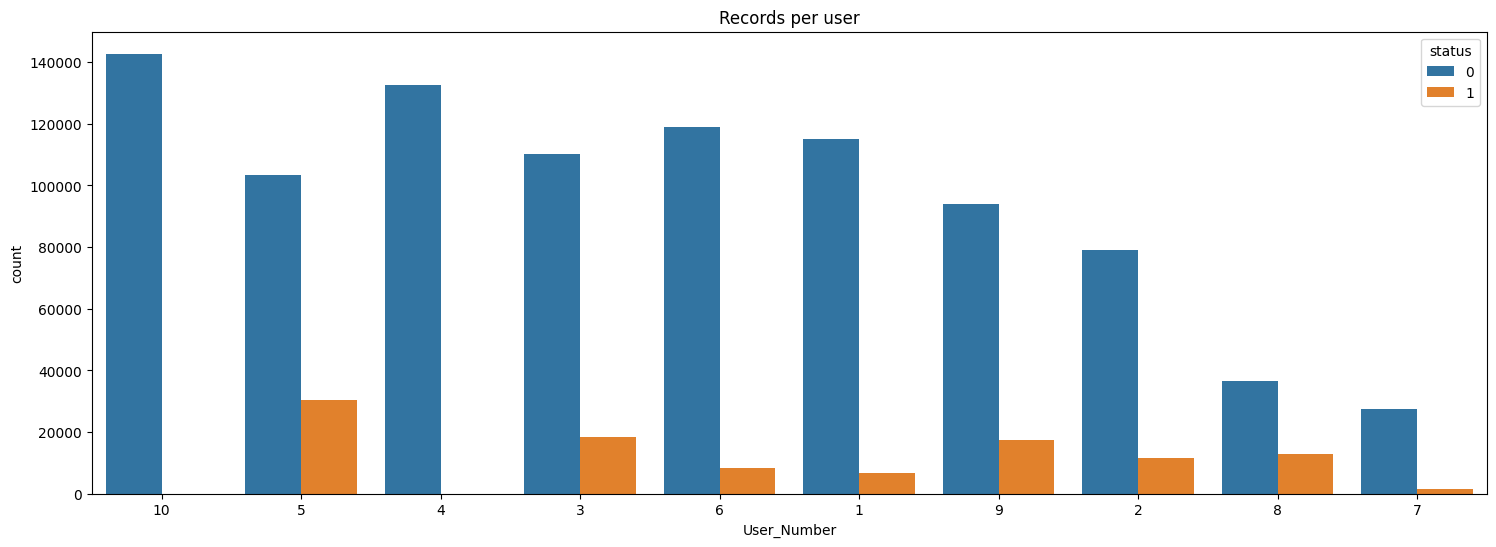

In [12]:
plt.figure(figsize=(18, 6))
sns.countplot(x = "User_Number", hue="status", data = df,
              order = df.User_Number.value_counts().index)
plt.title("Records per user");

In [13]:
from scipy import stats

def create_dataset(X, y, time_steps=1, step=1):
    Xs, ys = [], []
    for i in range(0, len(X) - time_steps, step):
        v = X.iloc[i:(i + time_steps)].values
        labels = y.iloc[i: i + time_steps]
        Xs.append(v)
        ys.append(stats.mode(labels)[0])
    return np.array(Xs), np.array(ys).reshape(-1, 1)

TIME_STEPS = 200
STEP = 40

X_data, y_data = create_dataset(df[['TS', ' Ankel_1', 'Ankel_2', 'Ankel_3', 'Thigh_1', 'Thigh_2', 'Thigh_3',
       'Trunk_1', 'Trunk_2', 'Trunk_3']], df.status, TIME_STEPS,
                                  STEP)

X_train, X_test,y_train, y_test = train_test_split(X_data, y_data, test_size = 0.2, stratify=  y_data )
X_train, X_val, y_train, y_val  = train_test_split(X_train, y_train, test_size = 0.2, stratify=  y_train )
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(17062, 200, 10) (17062, 1)
(5332, 200, 10) (5332, 1)


In [14]:
'''
X = df[['TS', ' Ankel_1', 'Ankel_2', 'Ankel_3', 'Thigh_1', 'Thigh_2', 'Thigh_3',
       'Trunk_1', 'Trunk_2', 'Trunk_3']].values
y = df['status'].values.reshape(-1, 1)
'''

"\nX = df[['TS', ' Ankel_1', 'Ankel_2', 'Ankel_3', 'Thigh_1', 'Thigh_2', 'Thigh_3',\n       'Trunk_1', 'Trunk_2', 'Trunk_3']].values\ny = df['status'].values.reshape(-1, 1)\n"

In [15]:
'''
X_train, X_test,y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify= y)
X_train, X_val, y_train, y_val  = train_test_split(X_train, y_train, test_size = 0.2, stratify= y_train )
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
'''

'\nX_train, X_test,y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify= y)\nX_train, X_val, y_train, y_val  = train_test_split(X_train, y_train, test_size = 0.2, stratify= y_train )\nprint(X_train.shape, y_train.shape)\nprint(X_test.shape, y_test.shape)\n'

In [16]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(handle_unknown = "ignore", sparse_output = False)
enc = enc.fit(y_train)

y_train_hot = enc.transform(y_train)
y_test_hot = enc.transform(y_test)
y_val_hot = enc.transform(y_val)

print(X_train.shape, y_train_hot.shape, X_test.shape, y_test_hot.shape)

(17062, 200, 10) (17062, 2) (5332, 200, 10) (5332, 2)


In [17]:
'''n_features, n_outputs = X_train.shape[1], y_train_hot.shape[1]'''

'n_features, n_outputs = X_train.shape[1], y_train_hot.shape[1]'

In [18]:
n_timesteps,n_features,n_outputs= X_train.shape[1],X_train.shape[2],y_train_hot.shape[1]
n_timesteps,n_features,n_outputs

(200, 10, 2)

## 데이터 밸런싱 전 모델

In [19]:
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dense(n_outputs, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 198, 64)           1984      
                                                                 
 dropout (Dropout)           (None, 198, 64)           0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 99, 64)           0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 6336)              0         
                                                                 
 dense (Dense)               (None, 128)               811136    
                                                                 
 dense_1 (Dense)             (None, 2)                 258       
                                                        

In [20]:
epochs, batch_size = 10, 128
history = model.fit(X_train, y_train_hot, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=(X_val, y_val_hot), shuffle=True)

Epoch 1/10
134/134 [==============================] - 6s 8ms/step - loss: 87126.7266 - accuracy: 0.8698 - val_loss: 2059.0930 - val_accuracy: 0.9018
Epoch 2/10
134/134 [==============================] - 1s 4ms/step - loss: 6250.1270 - accuracy: 0.8703 - val_loss: 4458.5649 - val_accuracy: 0.9018
Epoch 3/10
134/134 [==============================] - 1s 5ms/step - loss: 3219.6270 - accuracy: 0.8734 - val_loss: 701.2434 - val_accuracy: 0.9018
Epoch 4/10
134/134 [==============================] - 1s 4ms/step - loss: 1162.0575 - accuracy: 0.8769 - val_loss: 153.3329 - val_accuracy: 0.9018
Epoch 5/10
134/134 [==============================] - 0s 3ms/step - loss: 205.3791 - accuracy: 0.8698 - val_loss: 20.1546 - val_accuracy: 0.8933
Epoch 6/10
134/134 [==============================] - 0s 3ms/step - loss: 49.9011 - accuracy: 0.8661 - val_loss: 9.3485 - val_accuracy: 0.8964
Epoch 7/10
134/134 [==============================] - 0s 3ms/step - loss: 9.4711 - accuracy: 0.8657 - val_loss: 1.5818 - 

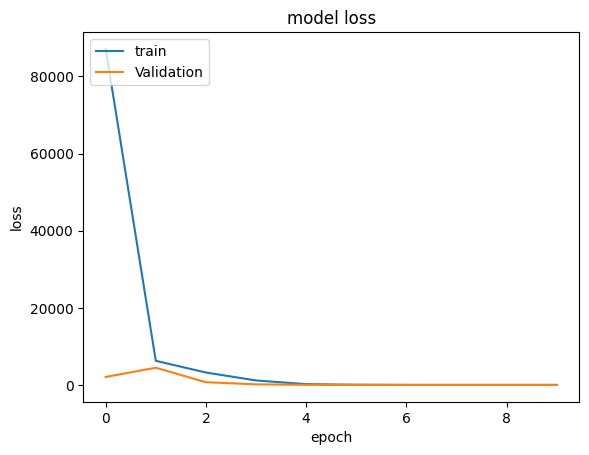

In [21]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

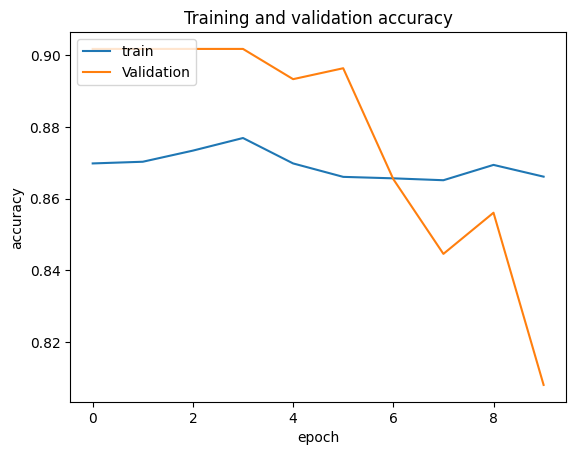

In [22]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

167/167 [==============================] - 0s 1ms/step
f1_score =  0.8392553536029854
0.8223930982745686
              precision    recall  f1-score   support

           0       0.93      0.87      0.90      4808
           1       0.24      0.38      0.30       524

    accuracy                           0.82      5332
   macro avg       0.59      0.63      0.60      5332
weighted avg       0.86      0.82      0.84      5332



<Axes: >

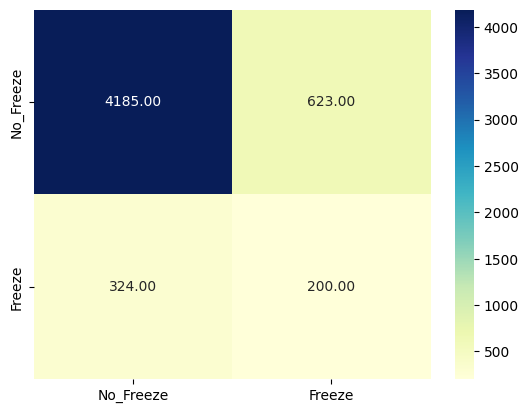

In [23]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

y_pred=model.predict(X_test)
y_pred = np.argmax(y_pred, axis=-1)
y_true = np.argmax(y_test_hot, axis=-1)

LABELS = ['No_Freeze','Freeze']
cm=confusion_matrix(y_true,y_pred)

#print(cm)
print('f1_score = ', f1_score(y_true, y_pred, average='weighted'))
print(accuracy_score(y_true,y_pred))
print(classification_report(y_true,y_pred))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

## Smote()를 통해 데이터 밸런싱

In [24]:
#Smote()를 통한 OverSampling
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = smote.fit_resample(df.drop('status', axis=1), df['status'])

In [25]:
df = pd.concat([pd.DataFrame(X_resampled, columns=df.drop('status', axis=1).columns),
                         pd.DataFrame({'status': y_resampled})], axis=1)

In [26]:
print(df['status'].value_counts())

status
0    959685
1    959685
Name: count, dtype: int64


In [27]:
df.head()

,TS,Ankel_1,Ankel_2,Ankel_3,Thigh_1,Thigh_2,Thigh_3,Trunk_1,Trunk_2,Trunk_3,User_Number,status
0,750000,-30,990,326,-45,972,181,-38,1000,29,1,0
1,750015,-30,1000,356,-18,981,212,-48,1028,29,1,0
2,750031,-20,990,336,18,981,222,-38,1038,9,1,0
3,750046,-20,1000,316,36,990,222,-19,1038,9,1,0
4,750062,0,990,316,36,990,212,-29,1038,29,1,0


In [28]:
df.shape

(1919370, 12)

I:\anaconda3\envs\test01\lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
I:\anaconda3\envs\test01\lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


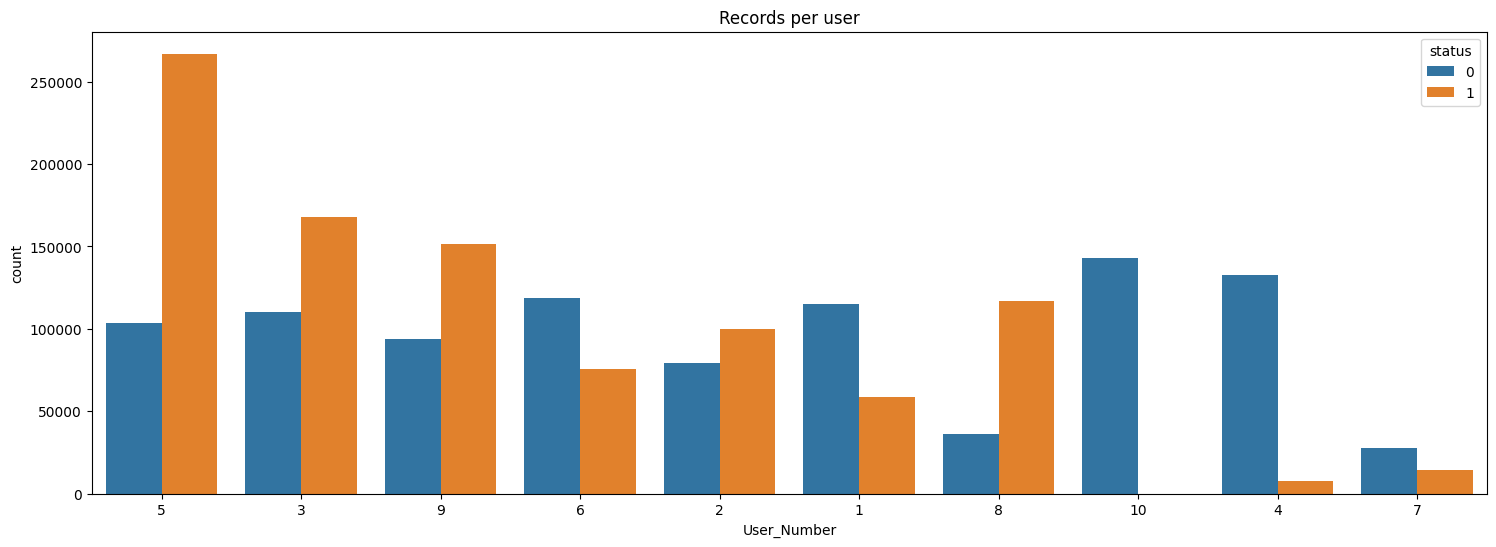

In [29]:
plt.figure(figsize=(18, 6))
sns.countplot(x = "User_Number", hue="status", data = df,
              order = df.User_Number.value_counts().index)
plt.title("Records per user");

In [30]:
from scipy import stats

def create_dataset(X, y, time_steps=1, step=1):
    Xs, ys = [], []
    for i in range(0, len(X) - time_steps, step):
        v = X.iloc[i:(i + time_steps)].values
        labels = y.iloc[i: i + time_steps]
        Xs.append(v)
        ys.append(stats.mode(labels)[0])
    return np.array(Xs), np.array(ys).reshape(-1, 1)

TIME_STEPS = 200
STEP = 40

X_data, y_data = create_dataset(df[['TS', ' Ankel_1', 'Ankel_2', 'Ankel_3', 'Thigh_1', 'Thigh_2', 'Thigh_3',
       'Trunk_1', 'Trunk_2', 'Trunk_3']], df.status, TIME_STEPS,
                                  STEP)

X_train, X_test,y_train, y_test = train_test_split(X_data, y_data, test_size = 0.2, stratify=  y_data )
X_train, X_val, y_train, y_val  = train_test_split(X_train, y_train, test_size = 0.2, stratify=  y_train )
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(30707, 200, 10) (30707, 1)
(9596, 200, 10) (9596, 1)


In [31]:
'''X = df[['TS', ' Ankel_1', 'Ankel_2', 'Ankel_3', 'Thigh_1', 'Thigh_2', 'Thigh_3',
       'Trunk_1', 'Trunk_2', 'Trunk_3']].values
y = df['status'].values.reshape(-1, 1)'''

"X = df[['TS', ' Ankel_1', 'Ankel_2', 'Ankel_3', 'Thigh_1', 'Thigh_2', 'Thigh_3',\n       'Trunk_1', 'Trunk_2', 'Trunk_3']].values\ny = df['status'].values.reshape(-1, 1)"

In [32]:
'''X_train, X_test,y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify= y)
X_train, X_val, y_train, y_val  = train_test_split(X_train, y_train, test_size = 0.2, stratify= y_train )
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)'''

'X_train, X_test,y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify= y)\nX_train, X_val, y_train, y_val  = train_test_split(X_train, y_train, test_size = 0.2, stratify= y_train )\nprint(X_train.shape, y_train.shape)\nprint(X_test.shape, y_test.shape)'

In [33]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(handle_unknown = "ignore", sparse_output = False)
enc = enc.fit(y_train)

y_train_hot = enc.transform(y_train)
y_test_hot = enc.transform(y_test)
y_val_hot = enc.transform(y_val)

print(X_train.shape, y_train_hot.shape, X_test.shape, y_test_hot.shape)

(30707, 200, 10) (30707, 2) (9596, 200, 10) (9596, 2)


In [34]:
n_timesteps,n_features,n_outputs= X_train.shape[1],X_train.shape[2],y_train_hot.shape[1]
n_timesteps,n_features,n_outputs

(200, 10, 2)

In [35]:
'''n_features, n_outputs = X_train.shape[1], y_train_hot.shape[1]'''

'n_features, n_outputs = X_train.shape[1], y_train_hot.shape[1]'

In [36]:
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dense(n_outputs, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 198, 64)           1984      
                                                                 
 dropout_1 (Dropout)         (None, 198, 64)           0         
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 99, 64)           0         
 1D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 6336)              0         
                                                                 
 dense_2 (Dense)             (None, 128)               811136    
                                                                 
 dense_3 (Dense)             (None, 2)                 258       
                                                      

In [37]:
epochs, batch_size = 10, 128
history = model.fit(X_train, y_train_hot, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=(X_val, y_val_hot), shuffle=True)

Epoch 1/10
240/240 [==============================] - 21s 60ms/step - loss: 16267.1299 - accuracy: 0.8884 - val_loss: 0.5509 - val_accuracy: 0.9457
Epoch 2/10
240/240 [==============================] - 10s 21ms/step - loss: 0.7604 - accuracy: 0.9456 - val_loss: 0.4125 - val_accuracy: 0.9457
Epoch 3/10
240/240 [==============================] - 1s 4ms/step - loss: 0.4836 - accuracy: 0.9456 - val_loss: 0.2810 - val_accuracy: 0.9457
Epoch 4/10
240/240 [==============================] - 6s 23ms/step - loss: 0.5162 - accuracy: 0.9457 - val_loss: 0.2552 - val_accuracy: 0.9457
Epoch 5/10
240/240 [==============================] - 5s 23ms/step - loss: 0.2753 - accuracy: 0.9456 - val_loss: 0.2355 - val_accuracy: 0.9457
Epoch 6/10
240/240 [==============================] - 6s 23ms/step - loss: 0.2574 - accuracy: 0.9455 - val_loss: 0.2206 - val_accuracy: 0.9457
Epoch 7/10
240/240 [==============================] - 5s 22ms/step - loss: 0.3956 - accuracy: 0.9456 - val_loss: 0.2093 - val_accuracy: 0

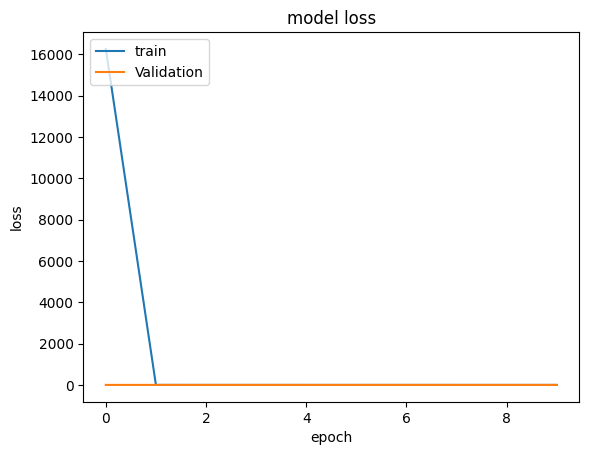

In [38]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

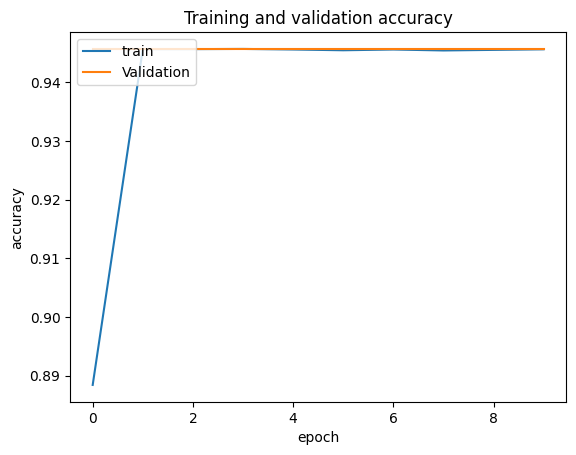

In [39]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

300/300 [==============================] - 0s 970us/step
f1_score =  0.9439620111197949
0.9441433930804501
              precision    recall  f1-score   support

           0       0.90      1.00      0.95      4808
           1       1.00      0.89      0.94      4788

    accuracy                           0.94      9596
   macro avg       0.95      0.94      0.94      9596
weighted avg       0.95      0.94      0.94      9596



<Axes: >

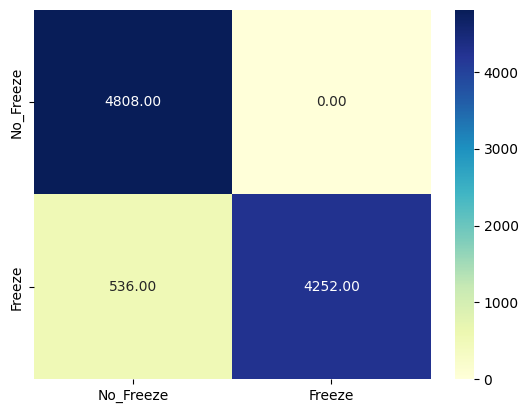

In [40]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

y_pred=model.predict(X_test)
y_pred = np.argmax(y_pred, axis=-1)
y_true = np.argmax(y_test_hot, axis=-1)

LABELS = ['No_Freeze','Freeze']
cm=confusion_matrix(y_true,y_pred)

#print(cm)
print('f1_score = ', f1_score(y_true, y_pred, average='weighted'))
print(accuracy_score(y_true,y_pred))
print(classification_report(y_true,y_pred))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')